In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
#from xgboost import plot_importance
#from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from utils.utils import remove_blacklisted, remove_redundant_columns, filter_device_groups
import joblib
from collections import defaultdict
import json
import tqdm
from utils.utils import smooth_seven_minute_intervals, simple_smooth, holt

SHIFT = -2
SMOOTH = 15

hc = 'HC212B'
#prefix = f'tr_20230127213409_{hc}_'
#y_name = f'LMAM_HC212B_PL-------_TPS'
#y_name = f'LMAM_HC212B_PLKL90---_TPG'
y_name = f'LMAM_HC212B_PLDT01---_TDI'
groups = ["1", "4", "5"]


# hc = 'HC201A'
# y_name = f'LMAM_{hc}_PLKL90---_TPG'
# groups = ["1", "2", "3"]

#df = pd.read_csv(f'dumbdata/{prefix}{y_name}.csv')
df = pd.read_csv(f'maybe.csv')

df = remove_blacklisted(df, file='feature_lists/blacklist15.txt')
df = remove_redundant_columns(df)
#print("LMAM_HC212B_NDXRPI1--_PV" in df.columns)
df = filter_device_groups(df, file='feature_lists/15groups.json', groups=groups, y_name=y_name, anti_groups=['y2'])

#print(df.columns)

# deduplicate 
##print(df.columns.value_counts())

#df = smooth_seven_minute_intervals(df=df, columns_to_smooth=df.columns.to_list(), minutes=20)
df = simple_smooth(df=df, columns_to_smooth=df.columns.to_list(), window_size=SMOOTH)
# df = simple_smooth(df=df, columns_to_smooth=df.columns.to_list(), window_size=5)
# df = holt(df, [y_name], alpha=0.9)
# df = holt(df, df.drop(columns=y_name).columns.to_list(), alpha=0.9)

with open('whitelist15_final.json', 'r') as f:
     to_take = json.load(f)
# to_take = [
#     "LMAM_PM212B_---------_TNI",
#     "LMAM_HC212B_NDDT01---_TDI",
#    "LMAM_HC212B_NDXRPI1--_PV"
# ]
df = df[to_take + [y_name]]




# with open('feature_lists/15cleaned_features.json', 'r') as f:
#     to_take = json.load(f)
# df = df[to_take + [y_name]]

df[y_name] = df[y_name].shift(SHIFT)
df = df[df[y_name].notnull()]


X = df.drop(columns=y_name).iloc[200:6200]
y = df[y_name].iloc[200:6200]

X_train = X.copy()
y_train = y.copy()

# KFOLD validation
k_splits = 10

fold_metrics = defaultdict(lambda: [])

y_pred_history = list()


for k in tqdm.tqdm(range(k_splits), desc='Training k-fold'):
    n = len(X_train)

    _from = k * n // k_splits
    _to = (k + 1) * n // k_splits

    fold_X_train = pd.concat([X_train.iloc[0:_from+1], X_train.iloc[_to:]])
    fold_y_train = pd.concat([y_train.iloc[0:_from+1], y_train.iloc[_to:]])

    fold_X_test = X_train.iloc[_from:_to]
    fold_y_test = y_train.iloc[_from:_to]

    model_name = 'linear'
    #model = RandomForestRegressor(n_jobs=3, n_estimators=50, max_depth=10)

    params={ 
        'objective':'reg:squarederror',
        'max_depth': 6, 
        'n_estimators': 40,
        'colsample_bylevel': 0.4,
        'colsample_bytree': 0.7,
        'learning_rate': 0.2,
        'subsample': 0.8,
        'alpha': 0.0,
        'lambda': 1.0,
        'gamma': 0.5,
        'random_state':20
         }
    
    model = XGBRegressor(**params)
    #model = RandomForestRegressor(n_jobs=4, max_depth=30, n_estimators=10)
    #model = LinearRegression()
    model.fit(fold_X_train, fold_y_train)

    y_pred = model.predict(fold_X_test)

    fold_mae = metrics.mean_absolute_error(fold_y_test, y_pred)
    fold_mse = metrics.mean_squared_error(fold_y_test, y_pred)
    fold_mape = metrics.mean_absolute_percentage_error(fold_y_test, y_pred)
    fold_r2 = metrics.r2_score(fold_y_test, y_pred)

    fold_metrics['mae'].append(round(fold_mae, 3))
    fold_metrics['mape'].append(fold_mape)
    fold_metrics['mse'].append(round(fold_mse, 3))
    fold_metrics['r2'].append(round(fold_r2, 3))

    y_pred_history.append(y_pred)

y_pred_history = np.concatenate(y_pred_history)

print('K-FOLD scores;')
for key, value in fold_metrics.items():
    print(f'{key}: {value};')

print(f"Mean mae {np.mean(fold_metrics['mae']):.2f};")
print(f"Mean mape {np.mean(fold_metrics['mape']):.2f}")
print(f"Mean mse {np.mean(fold_metrics['mse']):.2f};")
print(f"Mean r2 {np.mean(fold_metrics['r2']):.2f};")

Training k-fold: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

K-FOLD scores;
mae: [19.601, 10.073, 11.763, 18.171, 25.297, 15.094, 12.547, 17.585, 12.28, 10.881];
mape: [0.01732841376850192, 0.008958384166781002, 0.010563733968837044, 0.016509956793150368, 0.02210278476494676, 0.013266119898093303, 0.011280235761826457, 0.01608479714523269, 0.01089603022835477, 0.009648390485198005];
mse: [573.149, 166.799, 244.315, 520.552, 776.299, 333.591, 244.464, 485.395, 221.518, 160.151];
r2: [-1.302, -0.298, -0.183, -2.079, -4.188, -0.918, -0.769, -1.47, -0.384, -1.412];
Mean mae 15.33;
Mean mape 0.01
Mean mse 372.62;
Mean r2 -1.30;


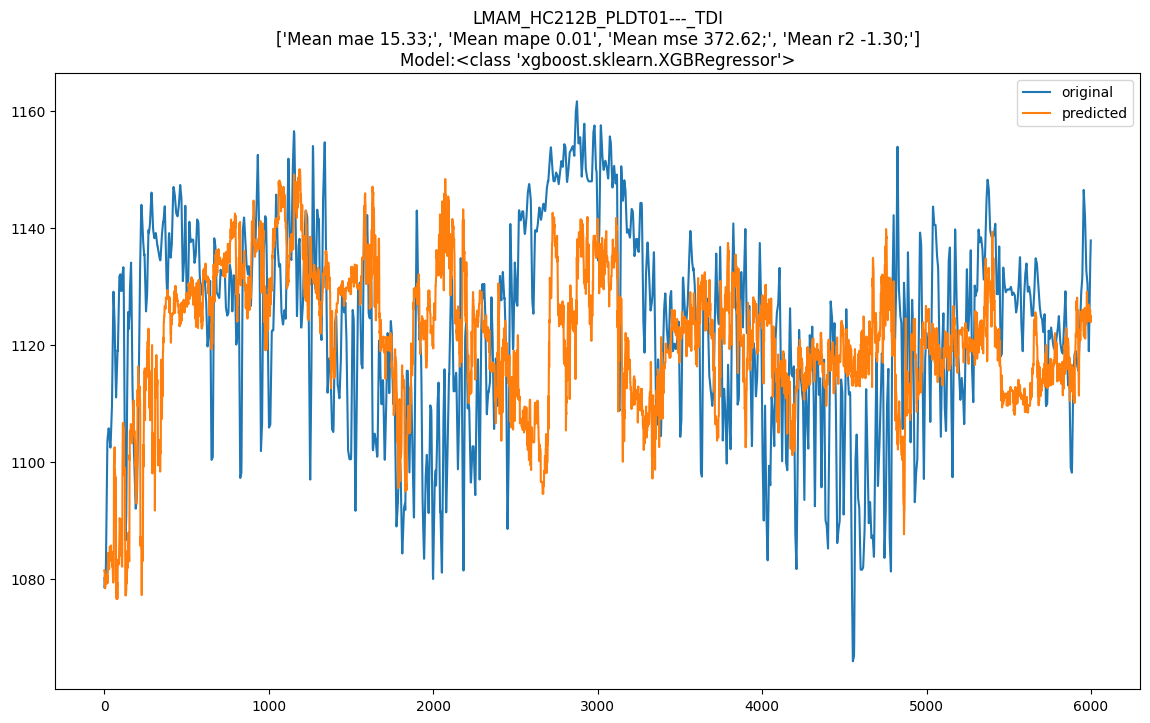

In [59]:
stats = [
f"Mean mae {np.mean(fold_metrics['mae']):.2f};",
f"Mean mape {np.mean(fold_metrics['mape']):.2f}",
f"Mean mse {np.mean(fold_metrics['mse']):.2f};",
f"Mean r2 {np.mean(fold_metrics['r2']):.2f};"
]

x_range = range(len(y_pred_history))
fig = plt.figure(figsize=(14,8))
plt.plot(x_range, y_train, label='original')
plt.plot(x_range, y_pred_history, label='predicted')
plt.title(f'{y_name}\n{stats}\nModel:{type(model)}')
plt.savefig(f'images/final/{y_name}.png')
plt.legend()

In [ ]:
plot_df = df.copy().iloc[2700:3600]
for col in df.columns:
    fig = plt.figure(figsize=(8,6))
    plt.plot(range(len(plot_df)), plot_df[col], label=col)
    plt.legend()

In [ ]:
# HYPERPARAMETERS OPTIMIZATION

# from sklearn.model_selection import RandomizedSearchCV

# params = { 'max_depth': [3, 5, 6, 10, 15, 20],
#            'learning_rate': [0.01, 0.1, 0.2, 0.3],
#            'subsample': np.arange(0.5, 1.0, 0.1),
#            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
#            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
#            'n_estimators': [50, 100, 500, 1000],
#             'lambda': [1.0, 0.8, 0.6],
#             'gamma': [1.0, 0.5, 0.1]
#         }

# reg = XGBRegressor(seed=20)
# clf = RandomizedSearchCV(
#     estimator=reg,
#     param_distributions=params,
#     n_iter=25,
#     scoring='r2',
#     verbose=1
# )

# clf.fit(X_train, y_train)
# print("Best parameters:", clf.best_params_)
# print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In [ ]:
# # force scores to be positive
# #scores = np.absolute(scores)
# print('-'*20)
# print('Scores')
# print(f'Mean MAE: {scores_mae.mean():.2f} +- {scores_mae.std():.2f}')
# print(f'Mean MSE: {scores_mse.mean():.2f} +- {scores_mse.std():.2f}')
# print(f'Mean R2: {scores_r2.mean():.2f} +- {scores_r2.std():.2f}')
# print('-'*20)
# print('Stats for Y')
# print(f'Min {y.min():.2f}')
# print(f'Max {y.max():.2f}')
# print(f'Mean {y.mean():.2f}')
# print(f'Std {y.std():.2f}')

# if model == 'xgb':
#     # plot feature importance
#     fig, ax = plt.subplots(ncols=3, figsize=(16,8))
#     plot_importance(model, max_num_features=20, ax=ax[0], title='weight', importance_type='weight')
#     plot_importance(model, max_num_features=20, ax=ax[1], title='gain', importance_type='gain')
#     plot_importance(model, max_num_features=20, ax=ax[2], title='cover', importance_type='cover')
#     plt.suptitle('XGBOOST internal feature importance')
#     plt.tight_layout()
#     plt.show()

# fig = plt.figure()

# error = y_test - test_pred
# plt.hist(error, bins=20)
# plt.title('Errors')
# plt.show()

# fig = plt.figure()

# test_n = len(test_pred)
# plt.plot(range(test_n), y_test, label='True')
# plt.plot(range(test_n), test_pred, label='Predicted')
# plt.legend()
# plt.show()

# fig = plt.figure()
# # Plot
# plt.hist(y, bins=20)
# plt.title(f'Y value for {y_name}')
# plt.xlabel('jednostka?')
# plt.tight_layout()
# plt.show()